In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "compare_trainings"

In [5]:
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:00<00:00,  1.27it/s]


In [6]:
bkg.reweight(2.3)
bkg.set_systematics(0.2)

[None, None]

In [7]:
def n_presel_jets(t):
    t.extend(n_presel_jet=t.n_jet)
(signal+bkg+data).apply(n_presel_jets)

[None, None, None, None, None]

In [8]:
# (signal+bkg).apply(lambda t : build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'), report=True)
t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)
signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
networks = dict(
    full_res_pn="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker/20221115_ranger_lr0.0047_batch512_m7m10m12/",
    full_res="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221124_ranger_lr0.0047_batch512_m7m10m12/",
    t8btag="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221128_ranger_lr0.0047_batch512_m7m10m12_t8btag/",
    # t8btag_bkg="/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-multiH/weaver/models/quadh_ranker_mp/20221128_ranger_lr0.0047_batch512_m7m10m12_t8btag_withbkg/",
)

In [10]:
def nfound_higgs(t):
    nhiggs = ak.sum(t.higgs_signalId>-1,axis=-1)
    t.extend(nfound_paired_h=nhiggs)

class Networks:
    def __init__(self, signal, bkg, data, quadh_path=None):
        self.signal = signal.copy()
        self.bkg = bkg.copy()
        self.data = data.copy()

        self.quadh_path = quadh_path

        (self.signal+self.bkg+self.data).apply(lambda t : eightb.load_quadh(t, quadh_path), report=True)
        self.signal.apply(nfound_higgs)

In [11]:
def higgs_m_asym(t):
    hm = t.higgs_m 
    h1, h2 = ak.unzip(ak.combinations(hm, 2, axis=-1))
    asym = (h1 - h2)/(h1 + h2)
    asym = np.sqrt( ak.sum(asym**2, axis=-1) )
    t.extend(higgs_m_asym=asym)

In [12]:
class DumpyClass(Networks):
    def __init__(self):
        self.signal = signal 
        self.bkg = bkg 
        self.data = data

        (self.signal+self.bkg+self.data).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ordered='pt'))
        (self.signal+self.bkg+self.data).apply(higgs_m_asym)
        (self.signal+self.bkg+self.data).apply(lambda t : t.extend(quadh_score=np.exp(-t.higgs_m_asym)))
        

In [13]:
nn = {
    key : Networks(signal, bkg, data, path)
    for key, path in networks.items()
}

100%|██████████| 5/5 [00:08<00:00,  1.76s/it]


In [14]:
nn['minmass'] = DumpyClass()

In [119]:
def avg_higgs_m(t):
    t.extend(avg_higgs_m=ak.mean(t.higgs_m,axis=-1))

for n in nn.values():
    (n.signal+n.bkg+n.data).apply(avg_higgs_m)

In [111]:
from scipy.optimize import fmin 


def get_variable_wp(variable, weight, bins=None, wps=[0.75,0.5,0.25], sf=True):
    h = Histo.from_array(variable, bins=bins, weights=weight)
    ecdf = h.ecdf(sf=sf)

    def _find_wp_(wp):
        wp = fmin(lambda x : (ecdf.evaluate(x)-wp)**2, h.stats.mean, full_output=False)
        return wp

    wps = np.concatenate([ _find_wp_(wp) for wp in wps ])

    return wps

In [112]:
for i, (key, n) in enumerate(nn.items()):
    n.signal_quadh_score_wp = get_variable_wp(n.signal.quadh_score.cat, n.signal.scale.cat)
    n.bkg_quadh_score_wp = get_variable_wp(n.bkg.quadh_score.cat, n.bkg.scale.cat)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 12
         Function evaluations: 24
Optimization terminated successful

100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


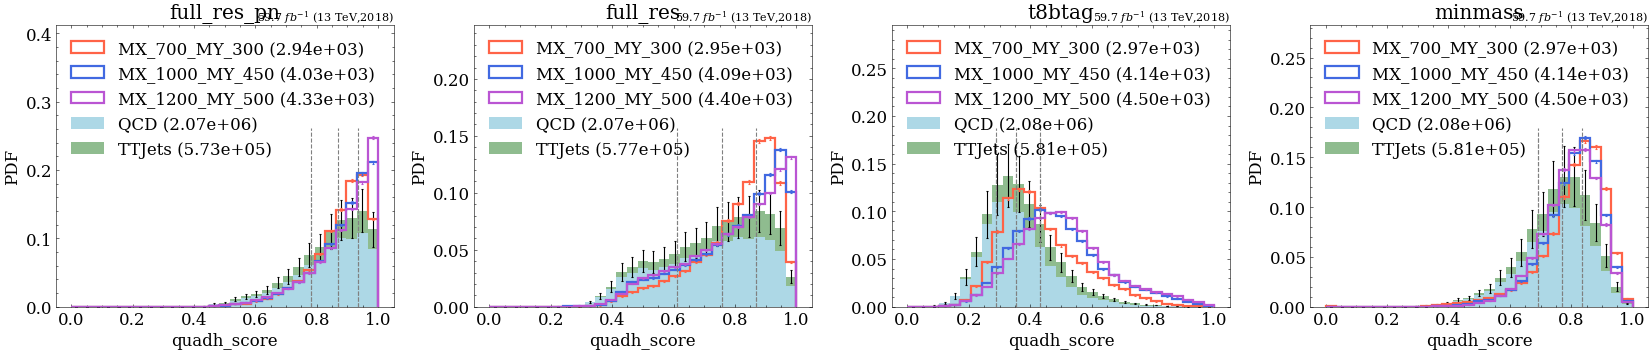

In [136]:
fig, axs = study.get_figax(len(nn), dim=-1)


for i, (key, n) in enumerate(nn.items()):
    def add_wp(ax=None, **kwargs):
        ylim = ax.get_ylim()
        for wp in n.bkg_quadh_score_wp: 
            ax.plot([wp, wp], ylim, color='grey', linestyle='--')

    study.quick( 
        n.signal + n.bkg, 
        legend=True, efficiency=True,
        varlist=[f'quadh_score'],
        binlist=[(0,1,30)],
        exe=add_wp,
        # **study.auroc,
        title=key,
        figax=(fig, axs.flat[i])
    )

In [134]:
class quadh_score_cut(ObjTransform):
    @property
    def __name__(self): return f"score > {self.cut:0.2f}"
    def __call__(self, t):
        return t.quadh_score > self.cut

100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


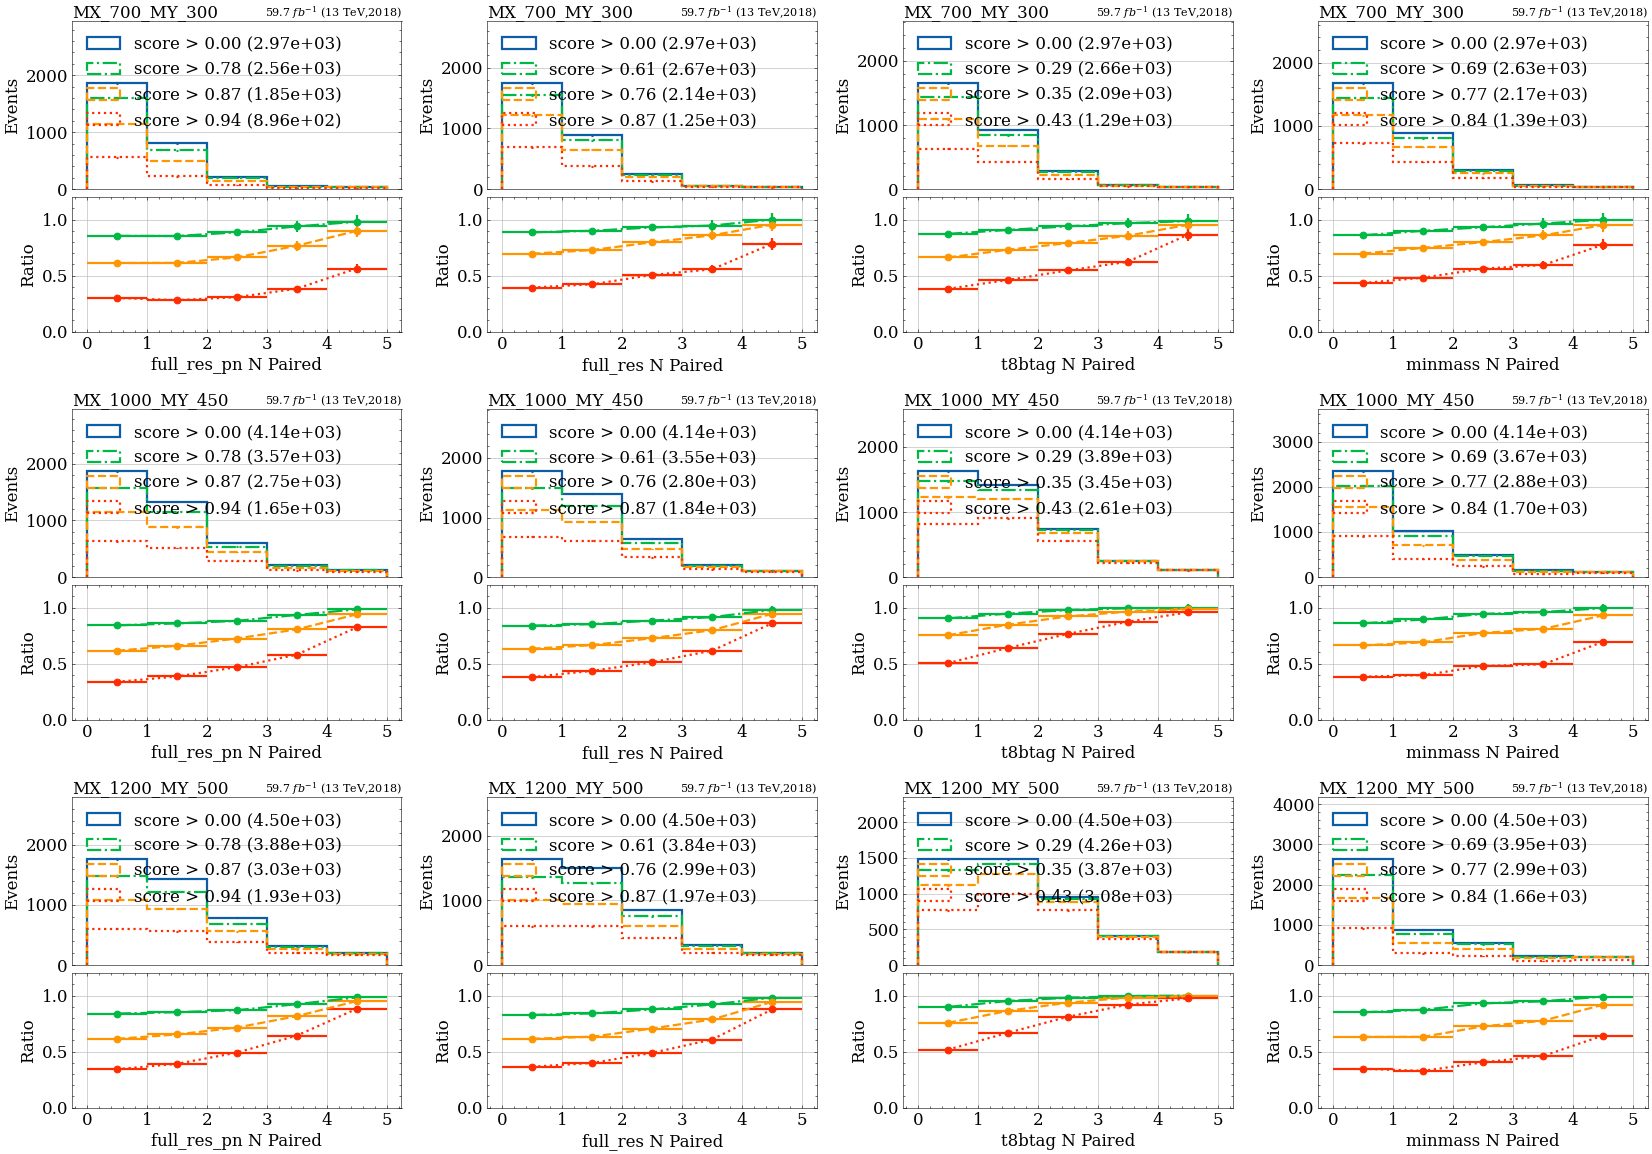

In [128]:
fig, axs = study.get_figax(3*len(nn), dim=(-1, len(nn)))
for i, (key, n) in enumerate(nn.items()):
    study.compare_masks( 
        n.signal, legend=True,
        # efficiency=True, cumulative=-1, 
        h_color=None,
        masks=[quadh_score_cut(cut=cut) for cut in np.append(0, n.bkg_quadh_score_wp)],
        varlist=['nfound_paired_h'],
        xlabels=[f'{key} N Paired'],
        # suptitle=key,
        grid=True,
        ratio=True, r_ylim=(0,1.2), r_inv=True, r_size="80%",
        figax=(fig, axs[:,i]),
    )

In [129]:

plt.style.use(['science','no-latex'])
plt.rcParams["figure.figsize"] = (6.5,6.5)
plt.rcParams['font.size'] =  15

100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

[ERROR] Unable to fit



100%|██████████| 1/1 [00:00<00:00,  1.96it/s]


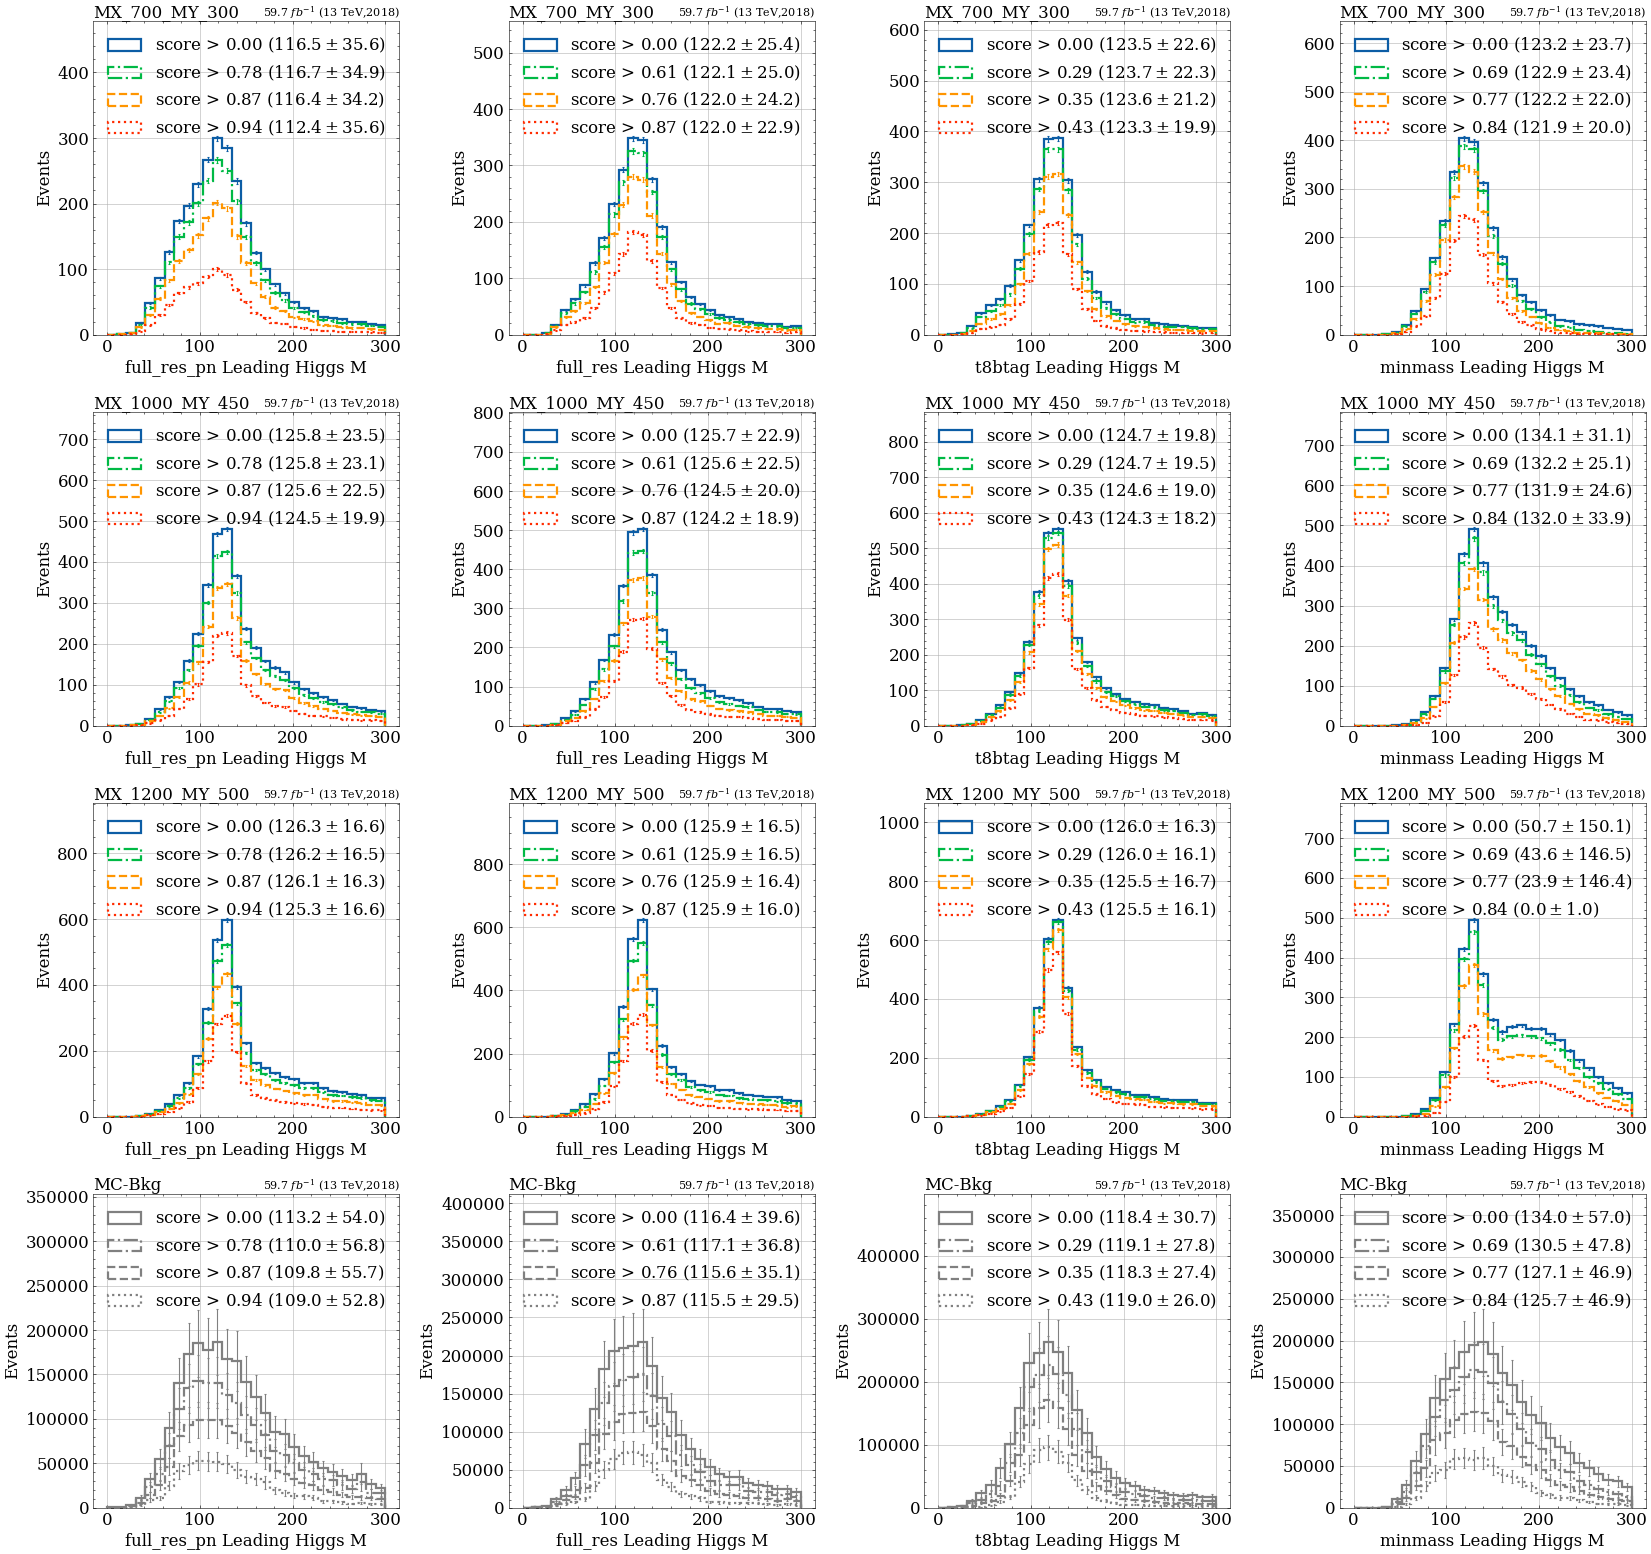

In [133]:
fig, axs = study.get_figax(4*len(nn), dim=(-1, len(nn)))
for i, (key, n) in enumerate(nn.items()):
    study.compare_masks( 
        n.signal,n.bkg, 
        legend=True,
        # efficiency=True, cumulative=-1, 
        h_color=None,
        masks=[quadh_score_cut(cut=cut) for cut in np.append(0, n.bkg_quadh_score_wp)],
        varlist=['higgs_m[:,0]'],
        binlist=[(0,300,30)],
        xlabels=[f'{key} Leading Higgs M'],
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        # suptitle=key,
        grid=True,
        # ratio=True, r_ylim=(0,1.2), r_inv=True, r_size="80%",
        figax=(fig, axs[:,i]),
    )

100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

[ERROR] Unable to fit



100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


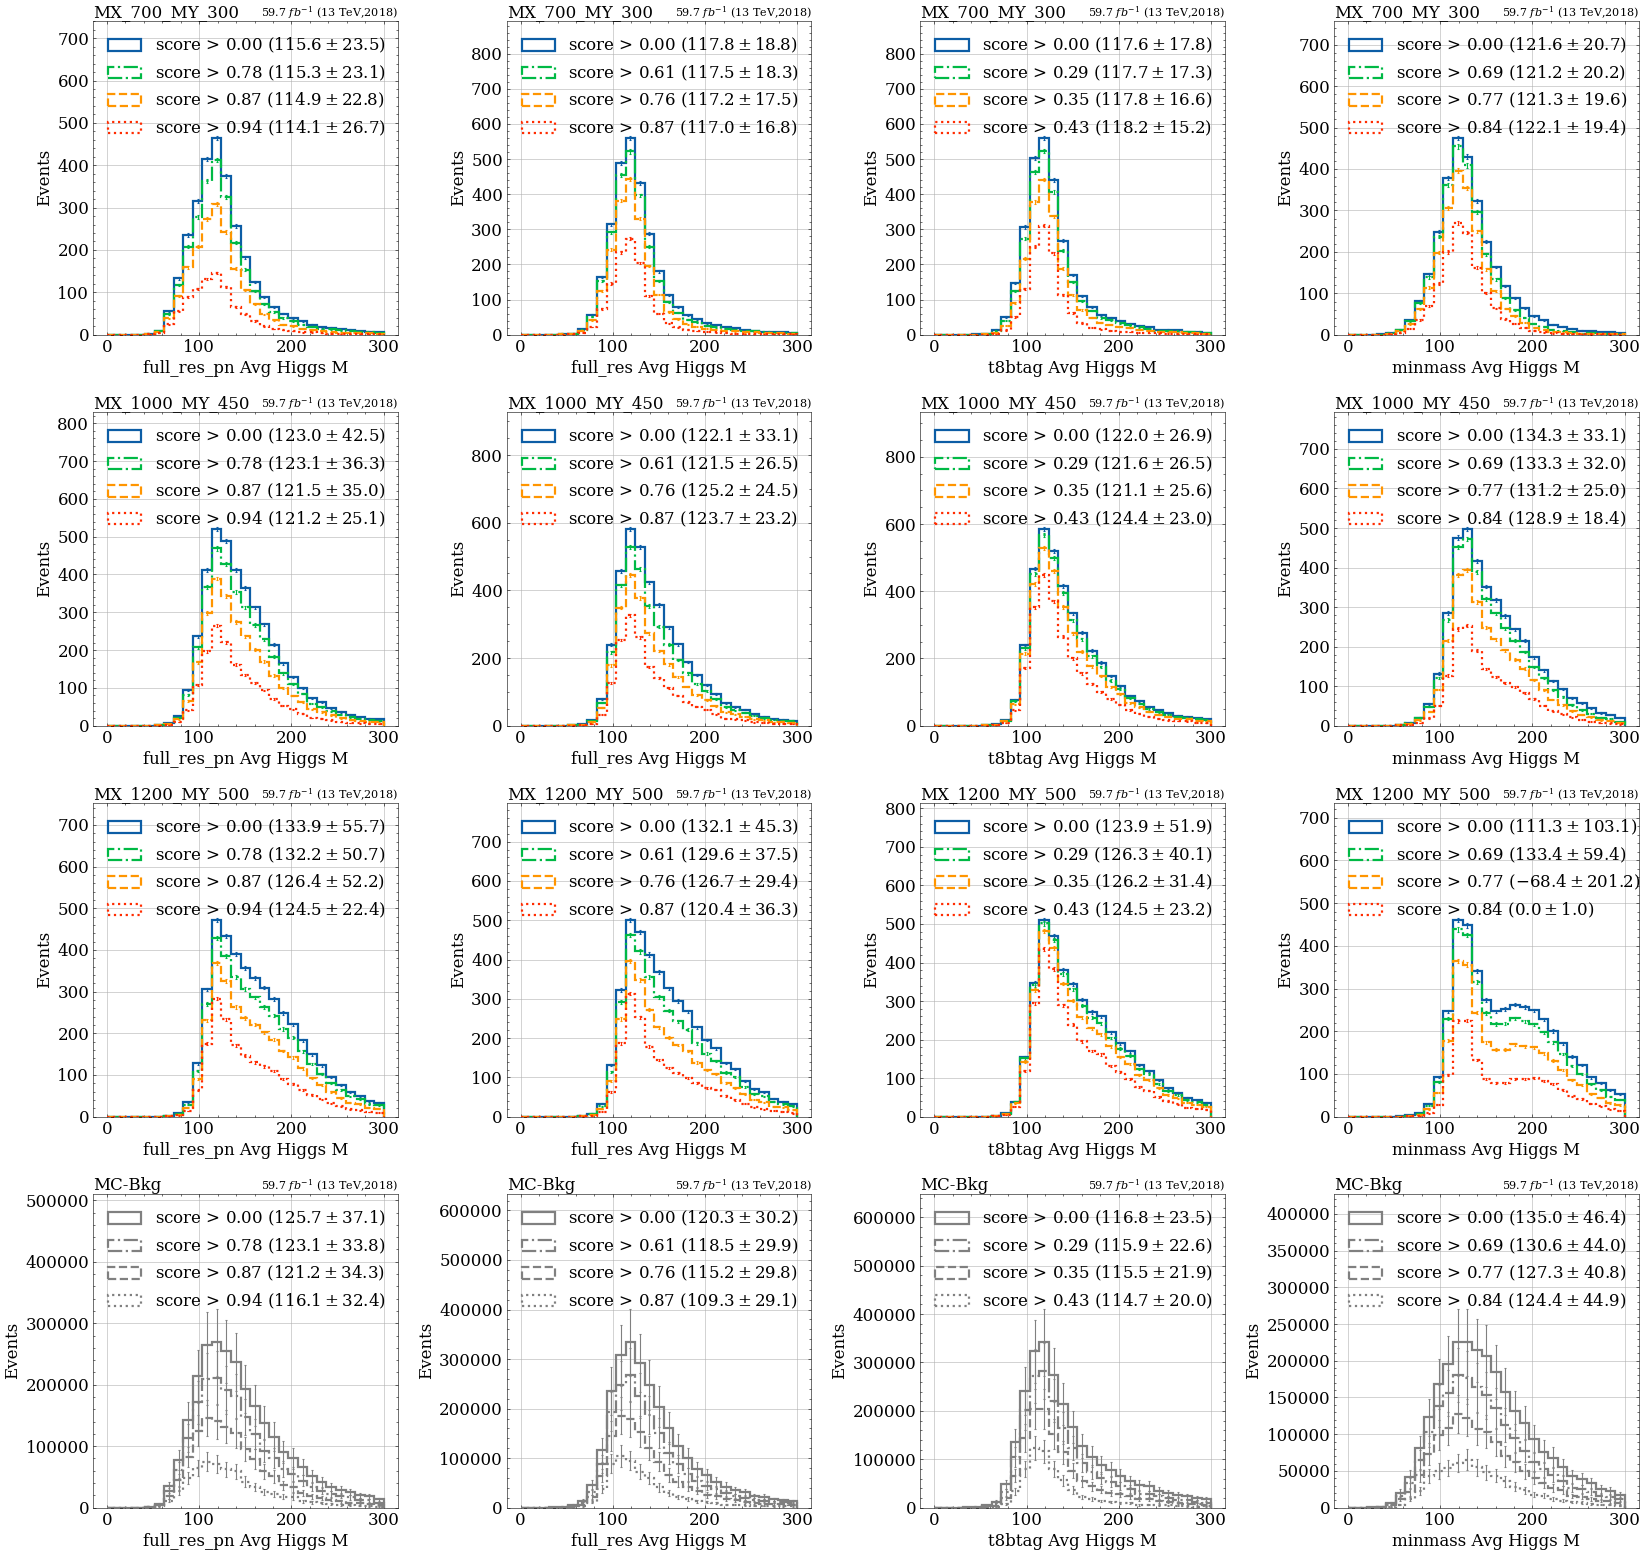

In [132]:
fig, axs = study.get_figax(4*len(nn), dim=(-1, len(nn)))
for i, (key, n) in enumerate(nn.items()):
    study.compare_masks( 
        n.signal,n.bkg, 
        legend=True,
        # efficiency=True, cumulative=-1, 
        h_color=None,
        masks=[quadh_score_cut(cut=cut) for cut in np.append(0, n.bkg_quadh_score_wp)],
        varlist=['avg_higgs_m'],
        binlist=[(0,300,30)],
        xlabels=[f'{key} Avg Higgs M'],
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        # suptitle=key,
        grid=True,
        # ratio=True, r_ylim=(0,1.2), r_inv=True, r_size="80%",
        figax=(fig, axs[:,i]),
    )

100%|██████████| 4/4 [00:02<00:00,  1.78it/s]


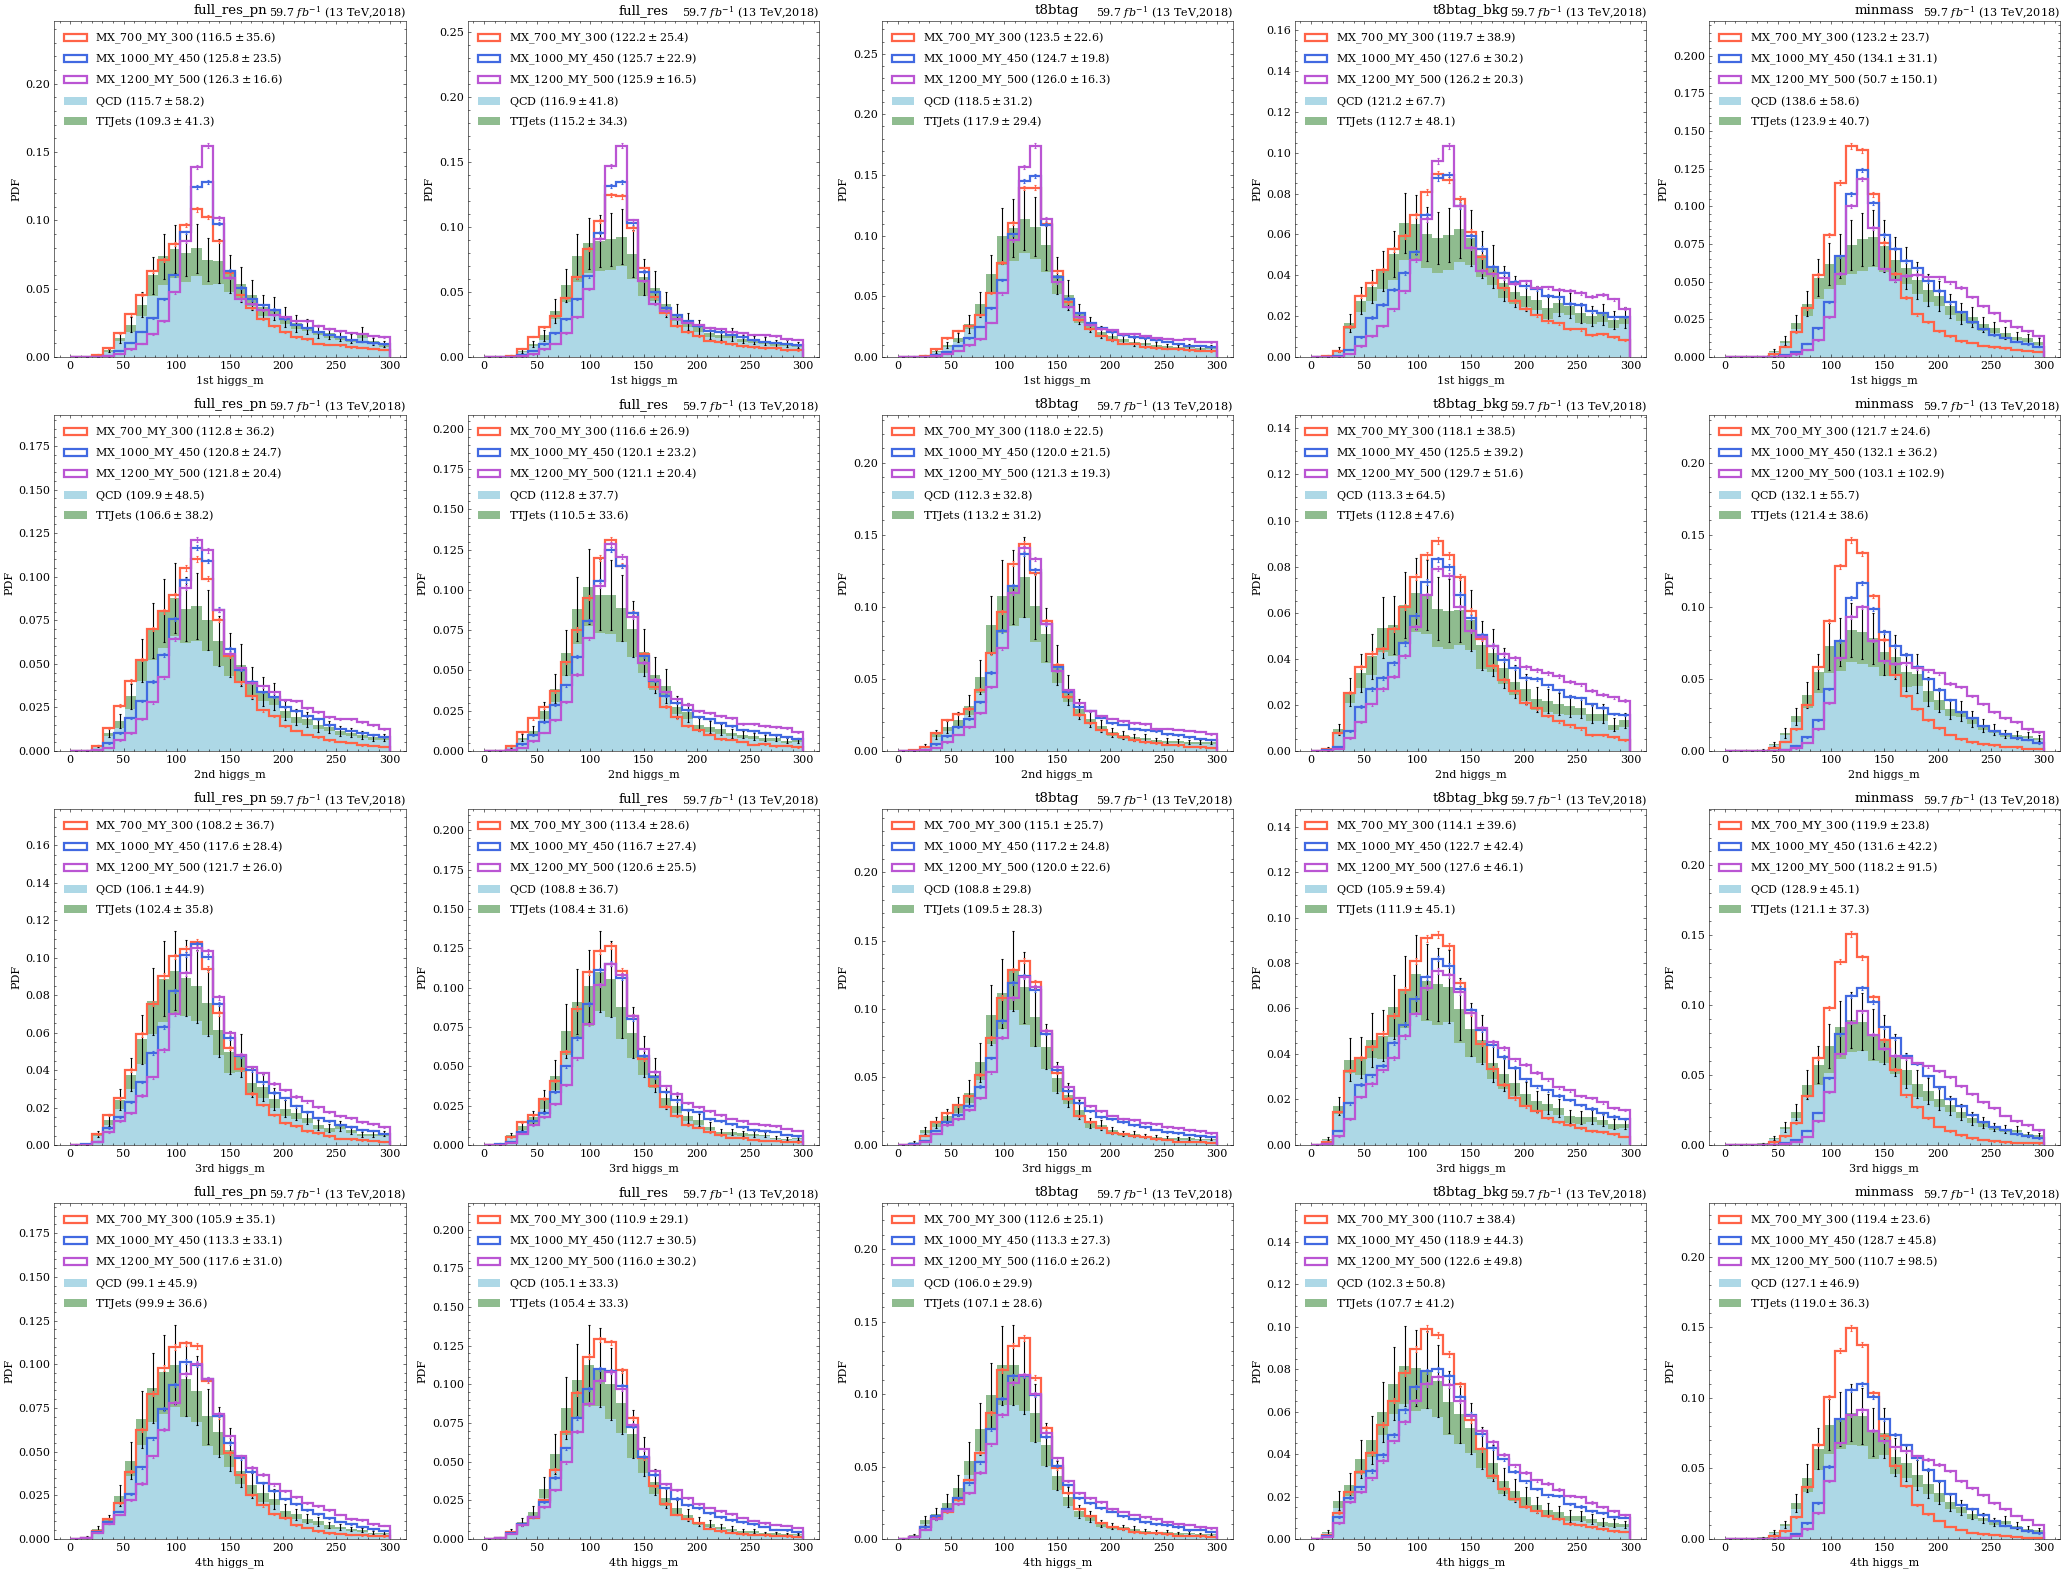

In [49]:
fig, axs = study.get_figax(4*5, dim=(-1, 5))

for i, (key, n) in enumerate(nn.items()):
    study.quick( 
        n.signal + n.bkg, 
        legend=True, efficiency=True,
        varlist=[f'higgs_m[:,{i}]' for i in range(4)],
        binlist=[(0,300,30)]*4,
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        title=key,
        figax=(fig, axs[:, i])
    )

100%|██████████| 1/1 [00:00<00:00,  1.11it/s]


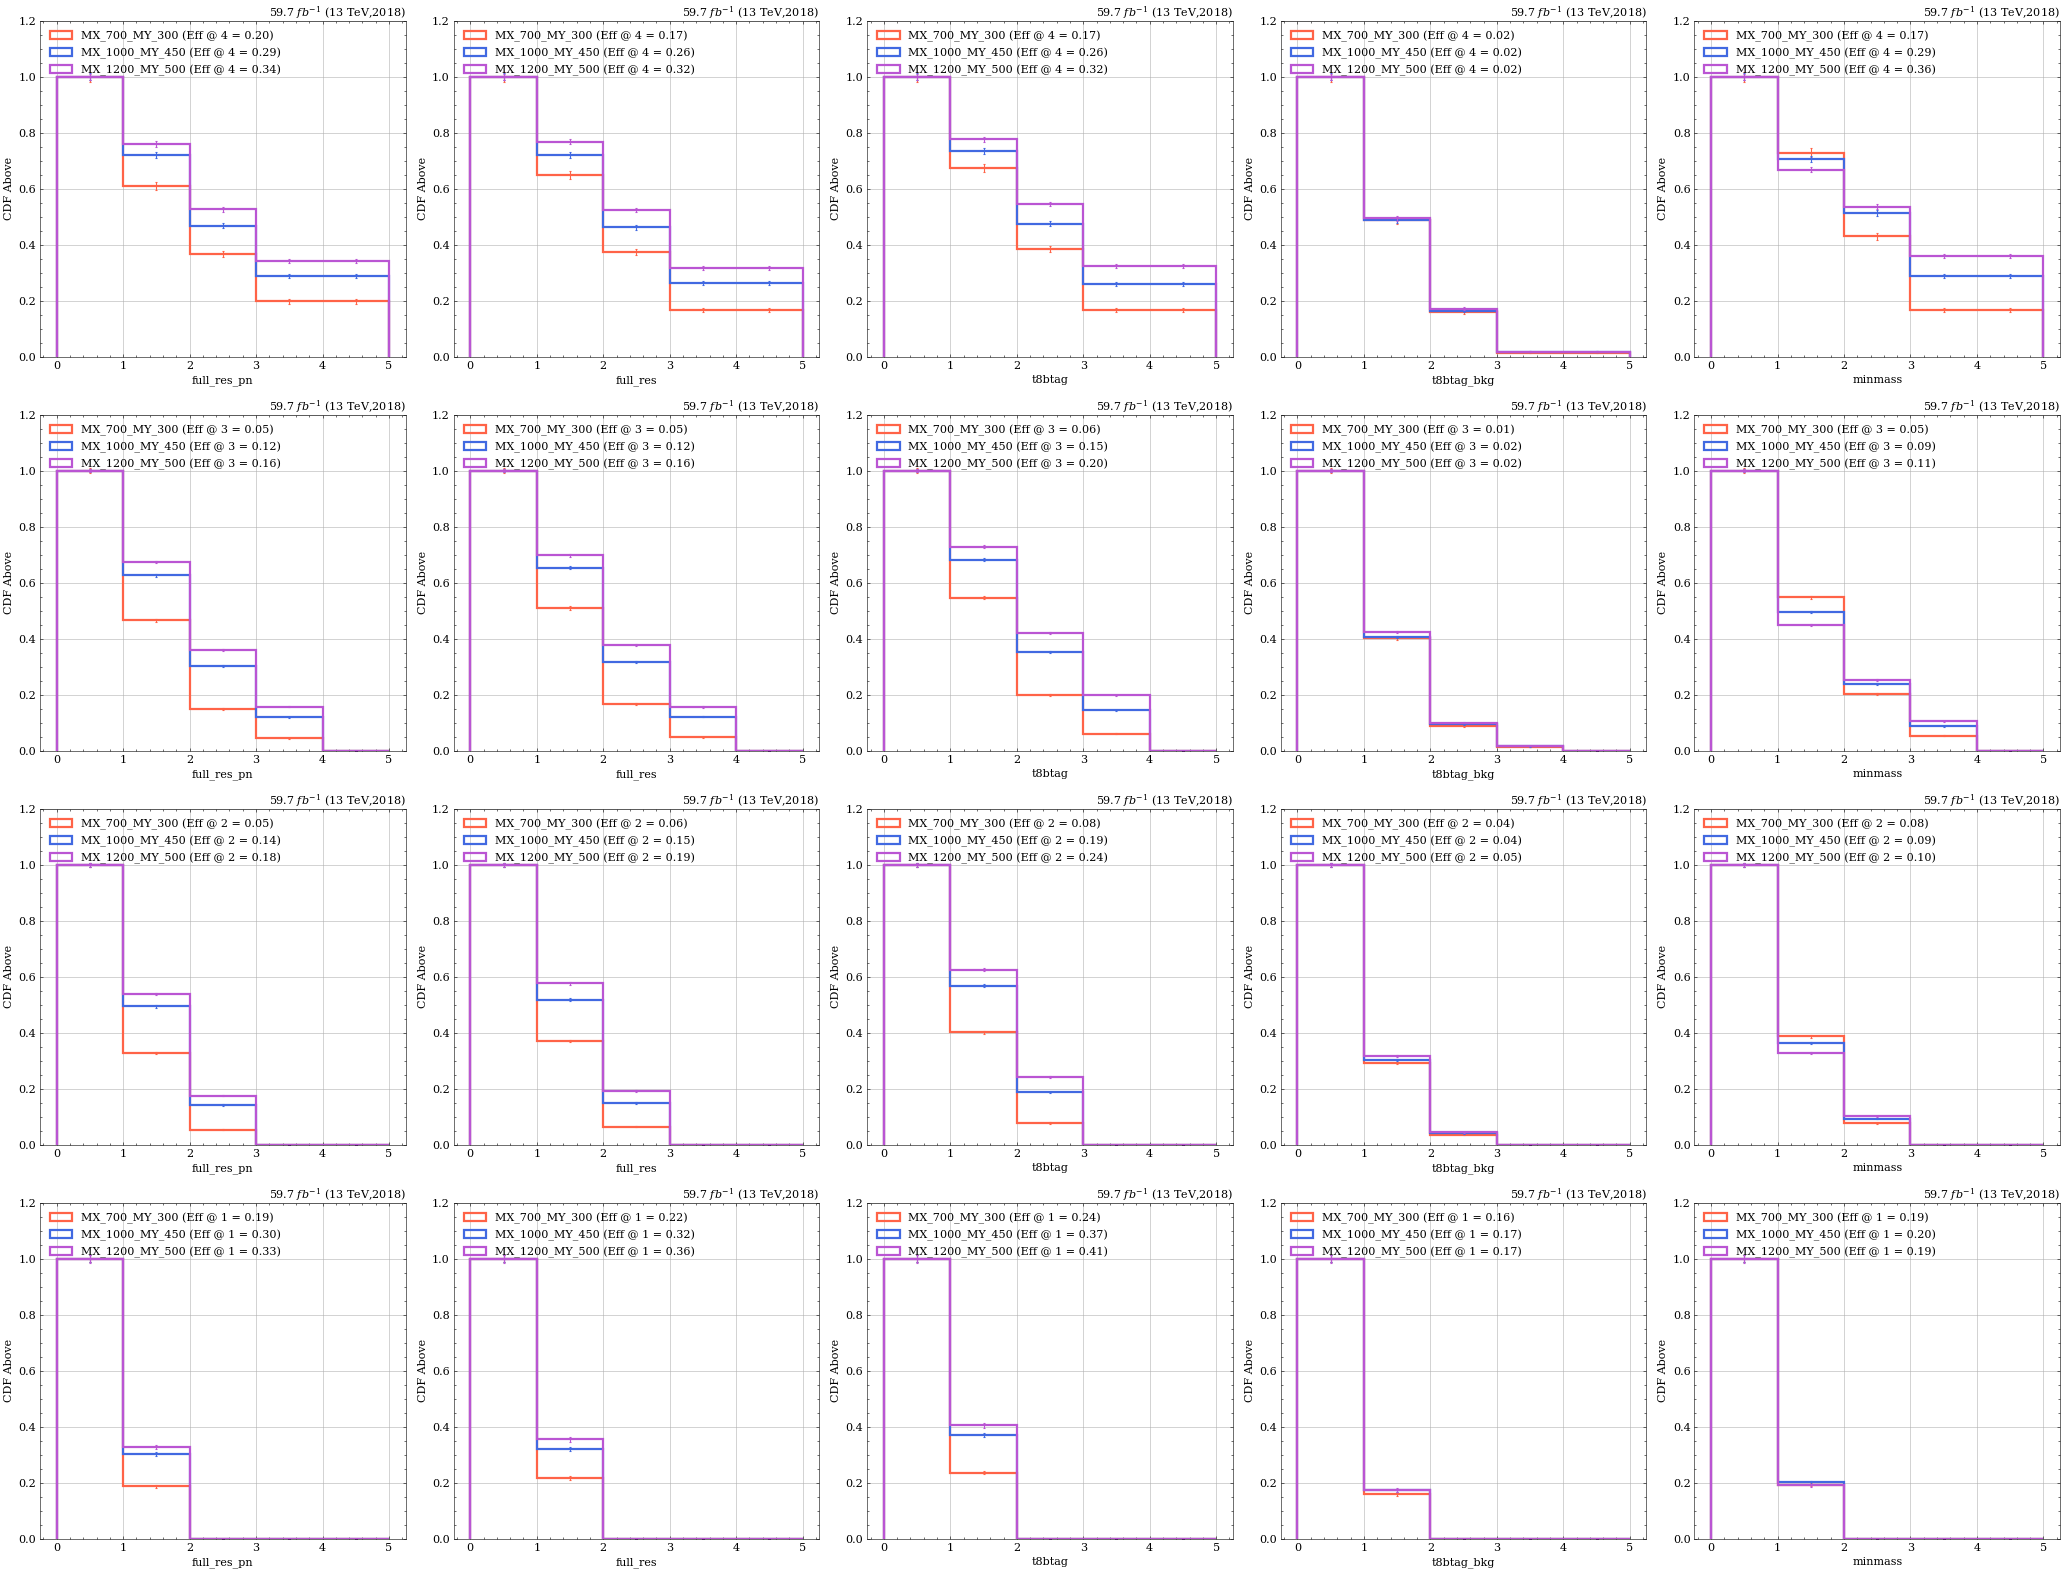

In [51]:
class higgs_eff(ObjTransform):
    def __call__(self, h):
        eff = ak.mean( h.array >= self.n )
        return f"Eff @ {self.n} = {eff:0.2f}"

class mask_select_h(ObjTransform):
    def __call__(self, t):
        return t.nfound_select_h == self.n

fig, axs = study.get_figax(4*5, dim=(-1, 5))
for j, nh in enumerate([4,3,2,1]):
    for i, (key, n) in enumerate(nn.items()):
        study.quick( 
            n.signal, 
            masks=mask_select_h(n=nh),
            h_label_stat=higgs_eff(n=nh), 
            legend=True, 
            efficiency=True,
            cumulative=-1,
            varlist=['nfound_paired_h'],
            binlist=[np.arange(6)],
            xlabels=[key],
            ylim=(0,1.2), grid=True,
            figax=(fig, axs[j, i])
        )

In [72]:
for i, (key, n) in enumerate(nn.items()):

100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


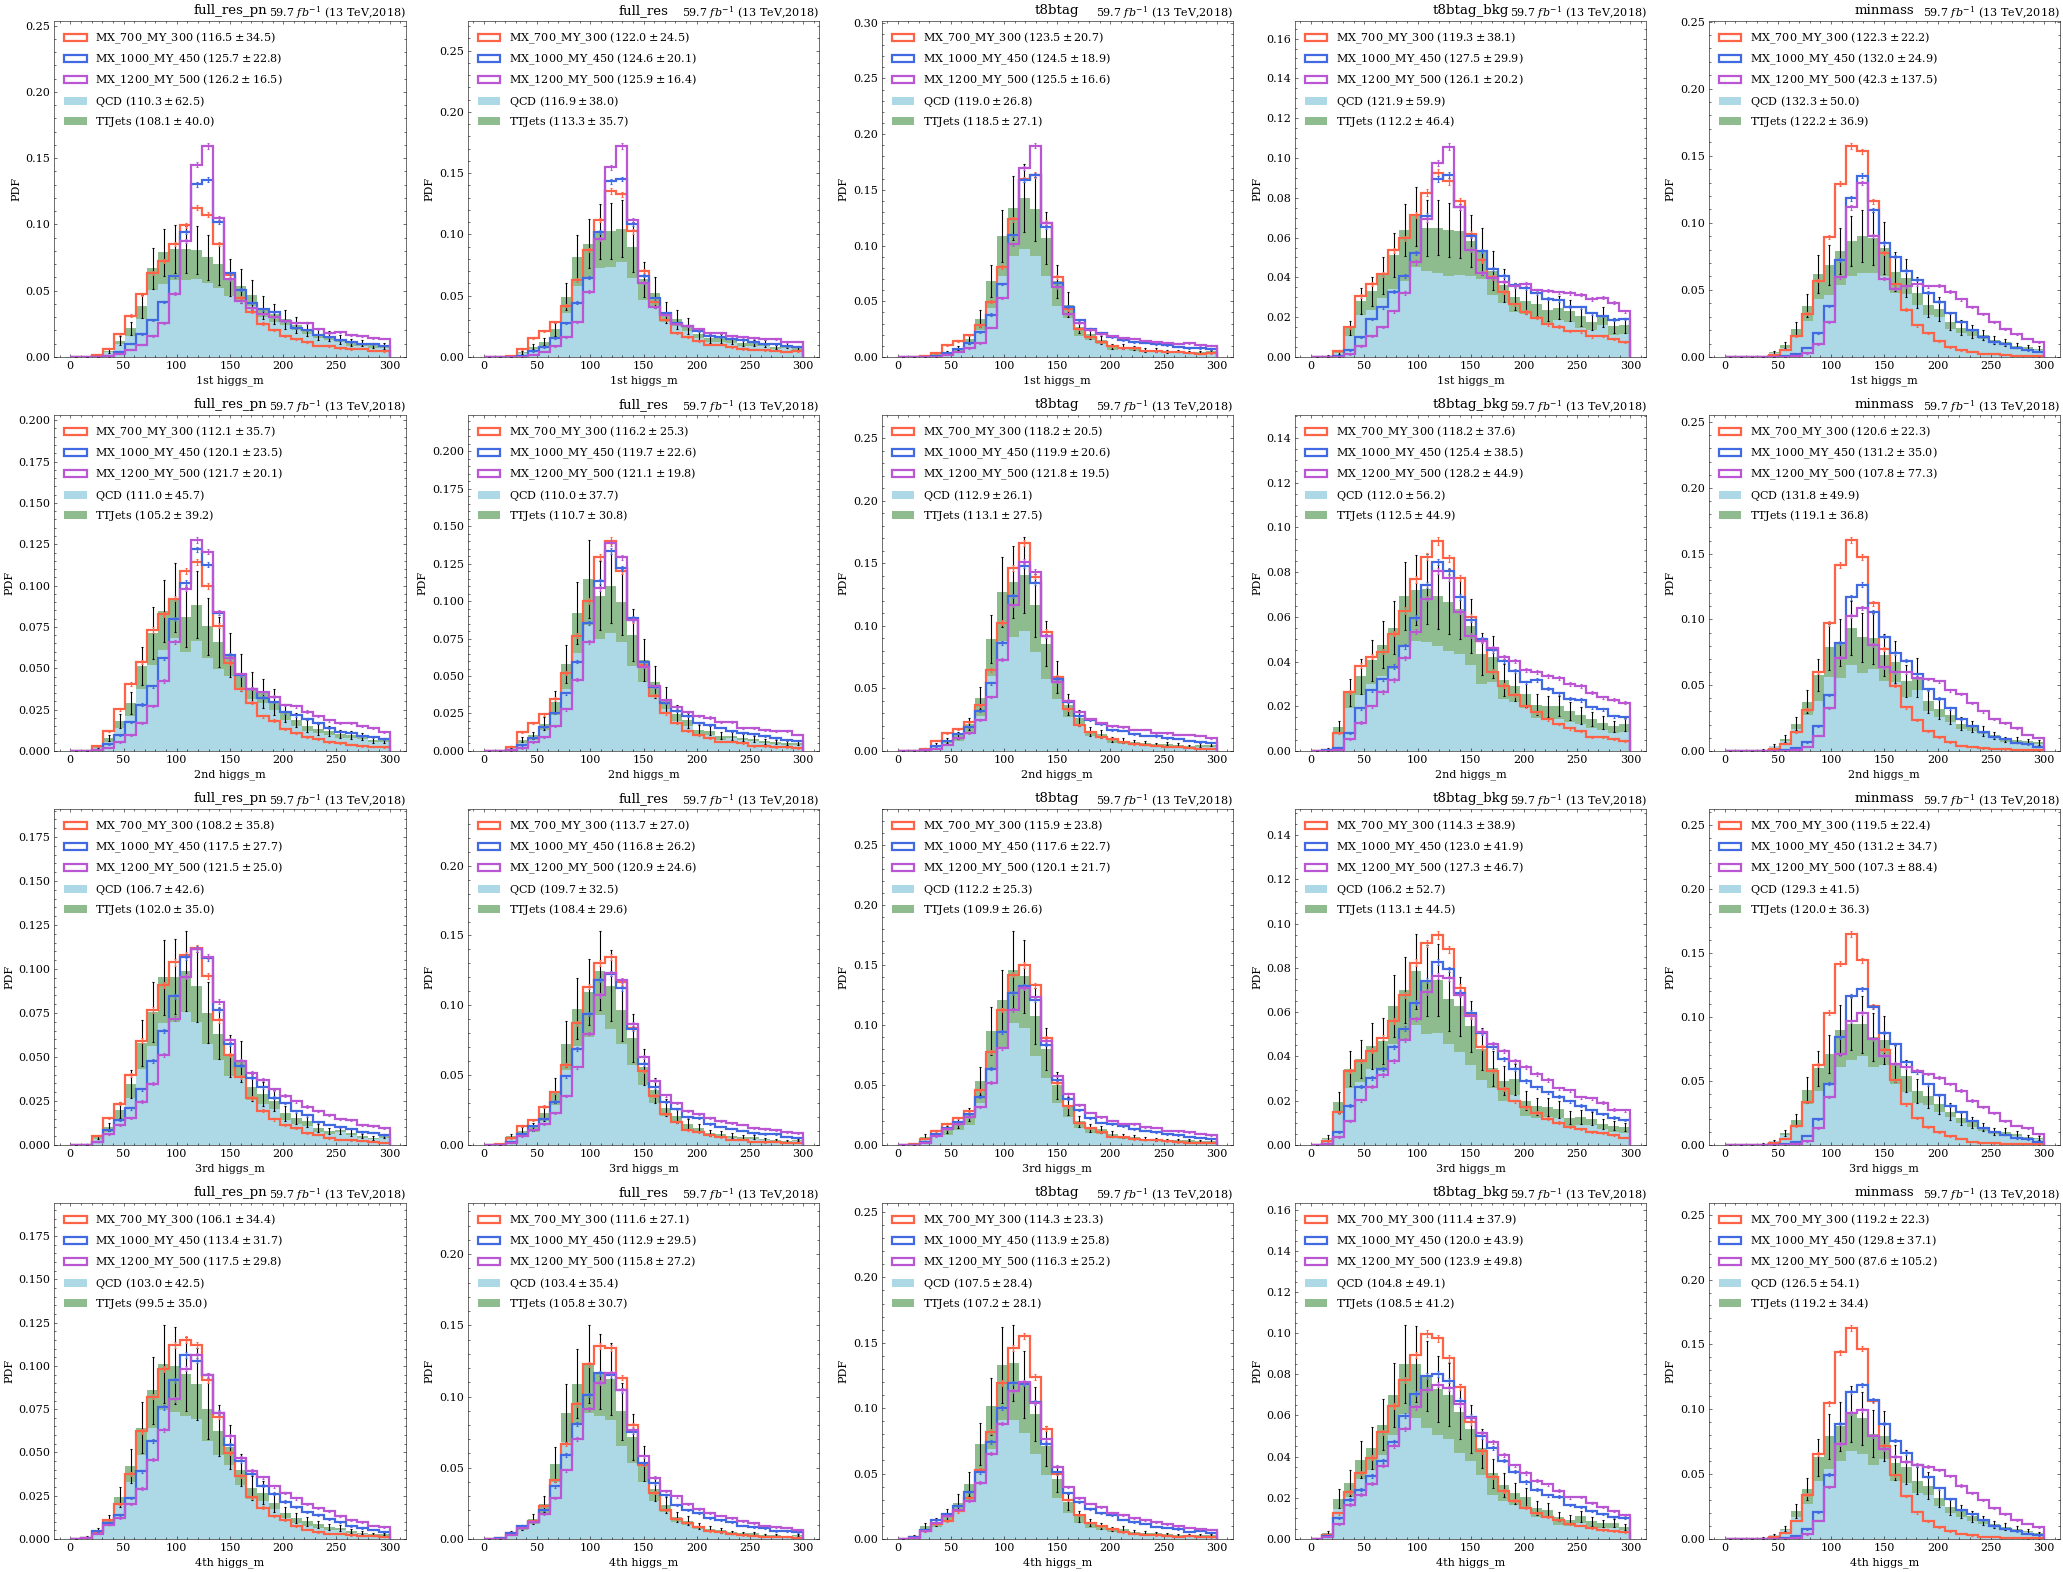

In [74]:
fig, axs = study.get_figax(4*5, dim=(-1, 5))

for i, (key, n) in enumerate(nn.items()):
    study.quick( 
        n.signal + n.bkg, 
        masks = lambda t : t.quadh_score > n.bkg_quadh_score_mu,
        legend=True, efficiency=True,
        varlist=[f'higgs_m[:,{i}]' for i in range(4)],
        binlist=[(0,300,30)]*4,
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        title=key,
        figax=(fig, axs[:, i])
    )

 50%|█████     | 2/4 [00:00<00:00,  2.53it/s]

[ERROR] Unable to fit


 75%|███████▌  | 3/4 [00:01<00:00,  2.40it/s]

[ERROR] Unable to fit


100%|██████████| 4/4 [00:01<00:00,  2.06it/s]

[ERROR] Unable to fit


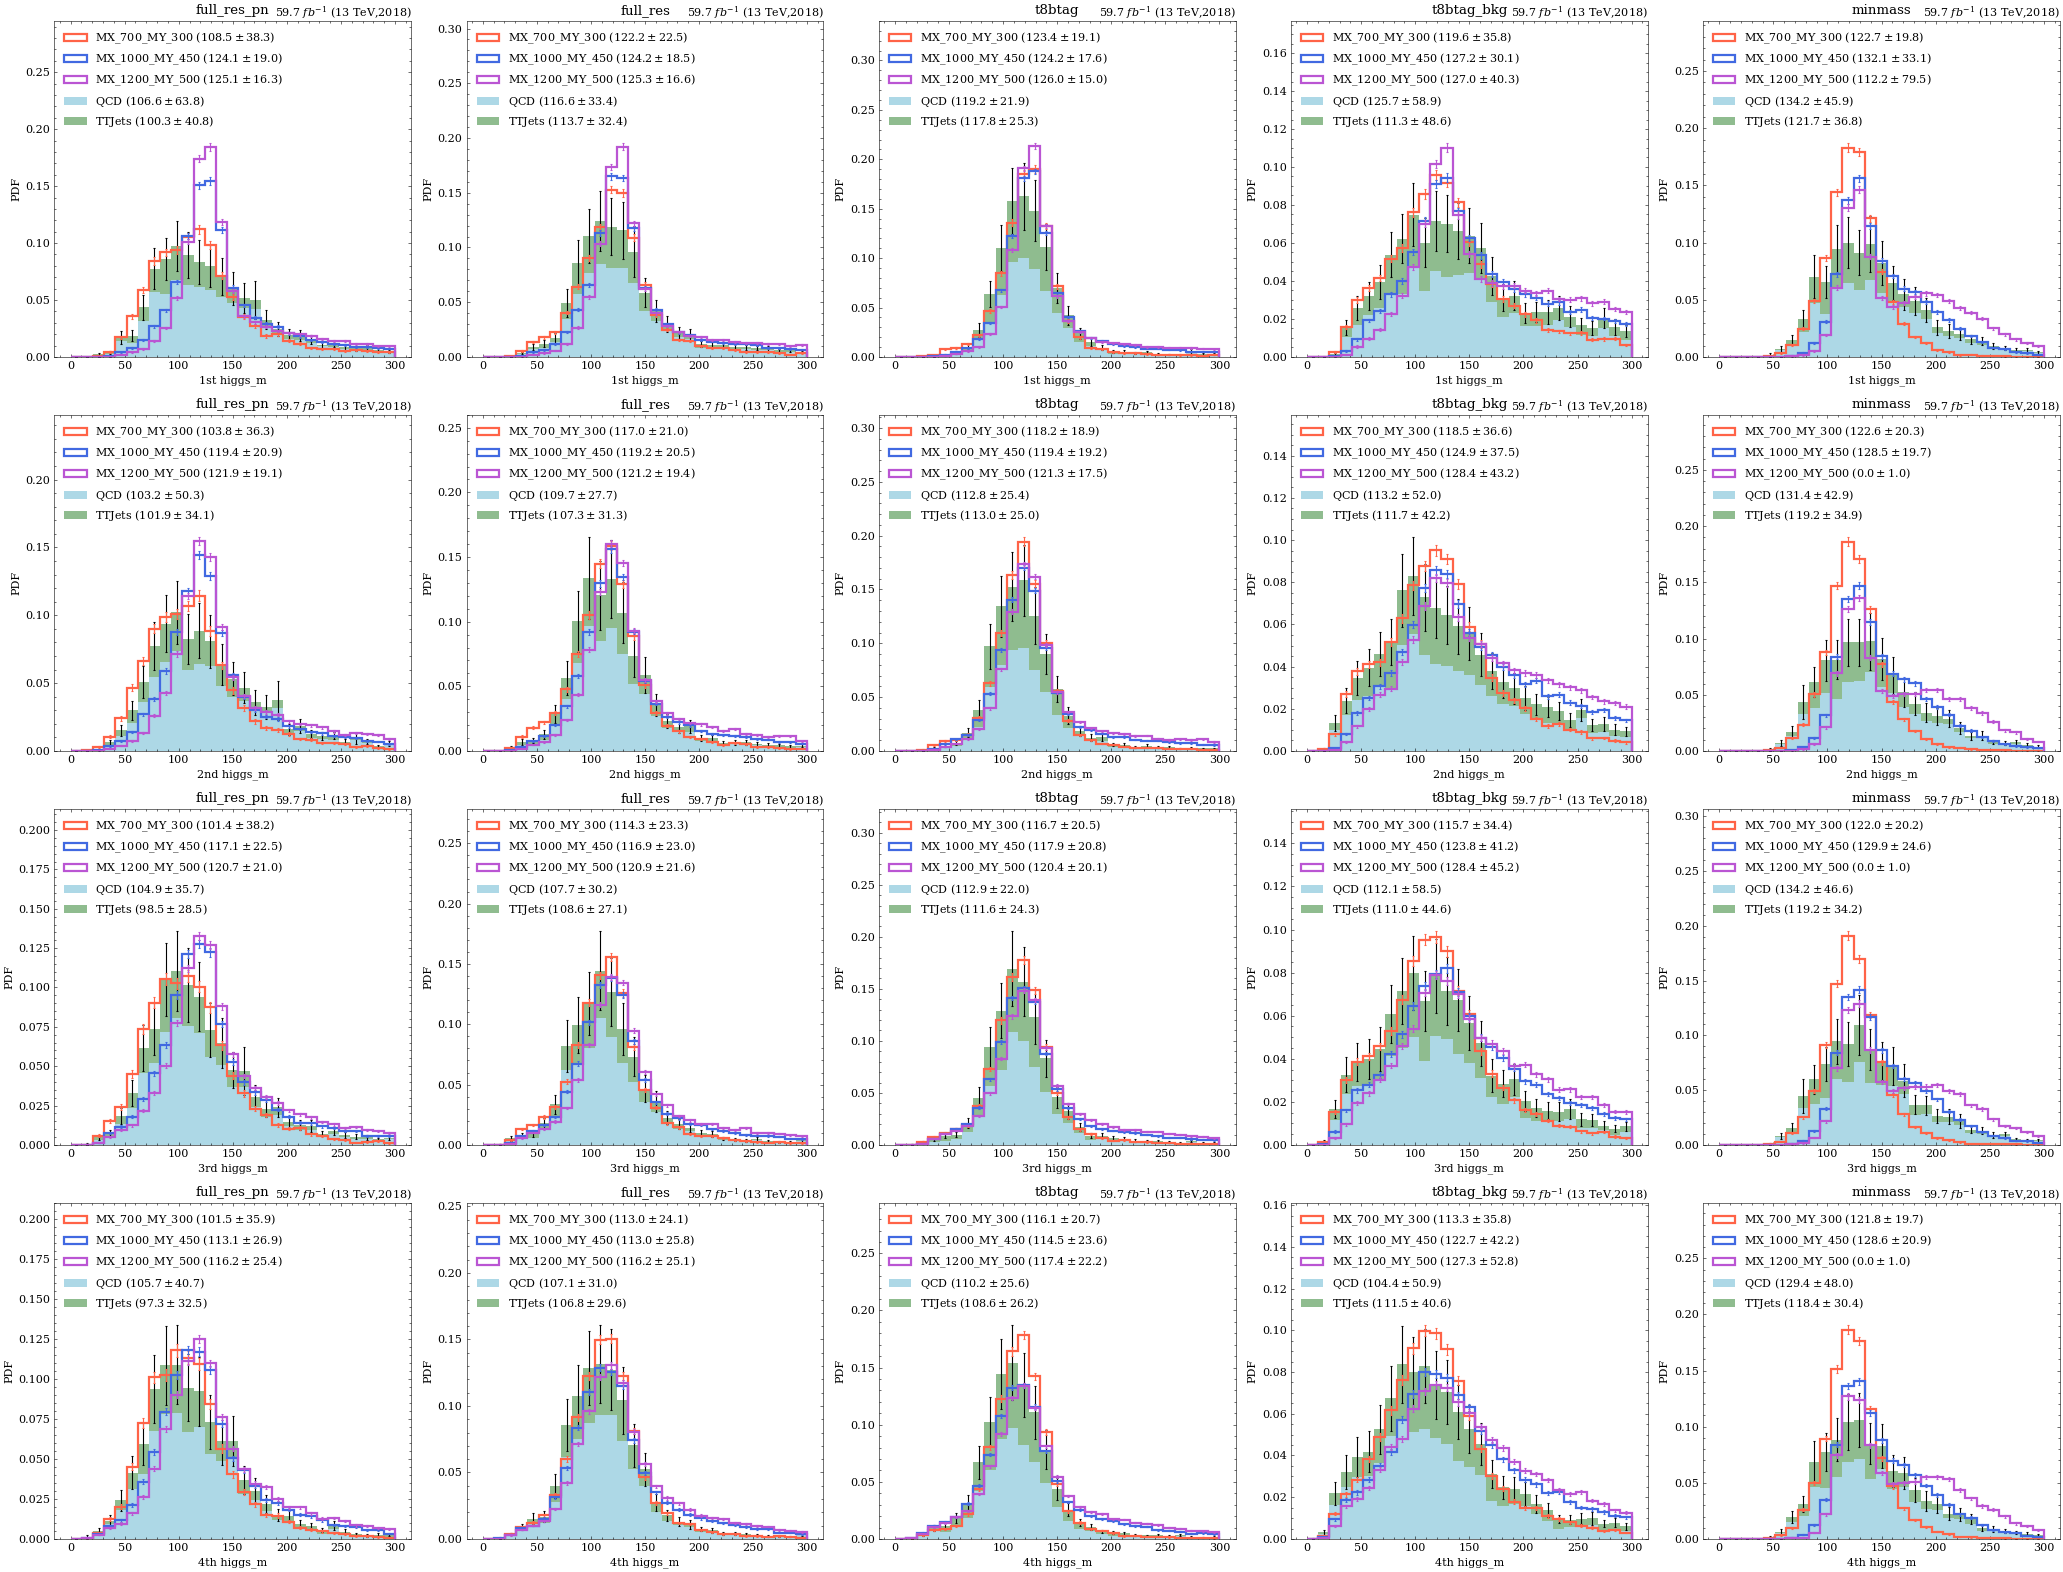

In [81]:
fig, axs = study.get_figax(4*5, dim=(-1, 5))

for i, (key, n) in enumerate(nn.items()):
    study.quick( 
        n.signal + n.bkg, 
        masks = lambda t : t.quadh_score > (n.bkg_quadh_score_mu+n.bkg_quadh_score_std),
        legend=True, efficiency=True,
        varlist=[f'higgs_m[:,{i}]' for i in range(4)],
        binlist=[(0,300,30)]*4,
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        title=key,
        figax=(fig, axs[:, i])
    )

100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


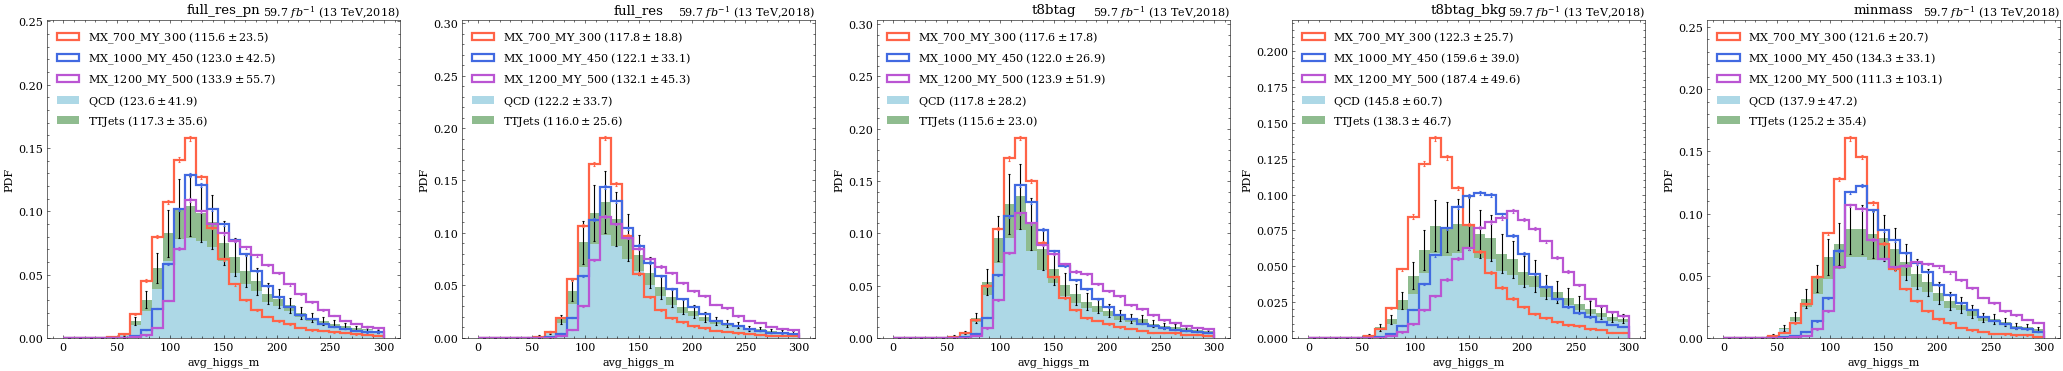

In [77]:
fig, axs = study.get_figax(5, dim=(-1, 5))

for i, (key, n) in enumerate(nn.items()):
    study.quick( 
        n.signal + n.bkg, 
        # masks = lambda t : t.quadh_score > n.bkg_quadh_score_mu,
        legend=True, efficiency=True,
        varlist=[f'avg_higgs_m'],
        binlist=[(0,300,30)],
        h_fit='gaussian', h_fit_peak=True, h_label_stat='${fit.mu:0.1f}\pm{fit.sigma:0.1f}$',
        title=key,
        figax=(fig, axs.flat[i])
    )

100%|██████████| 1/1 [00:04<00:00,  4.34s/it]


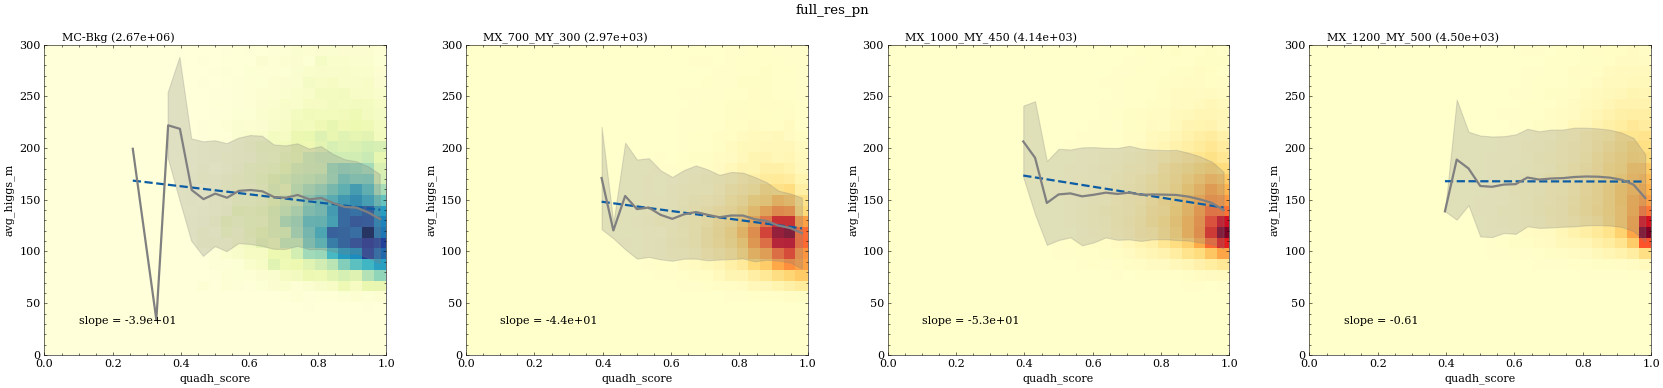

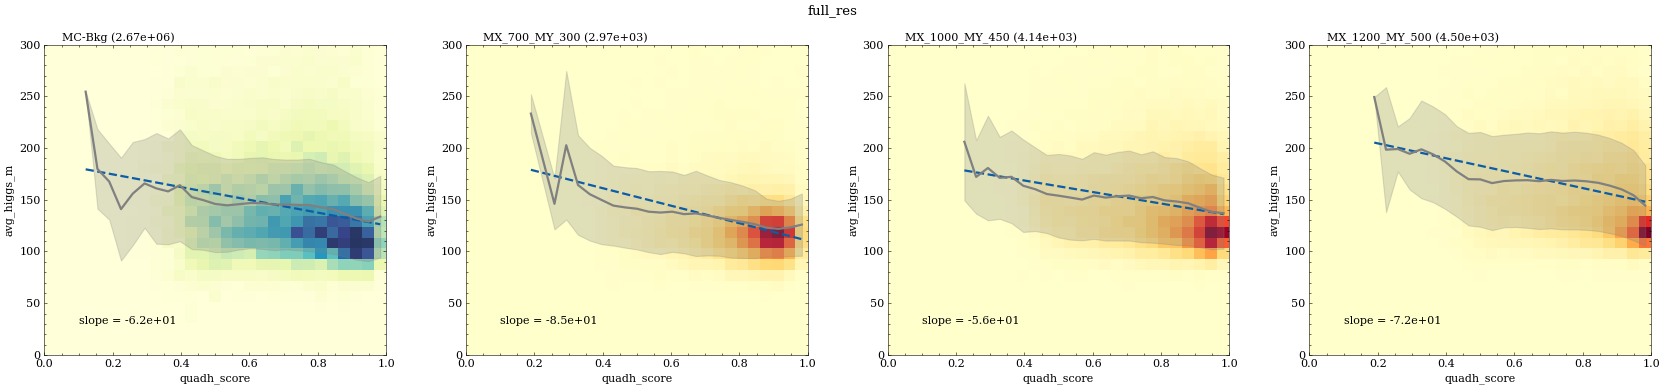

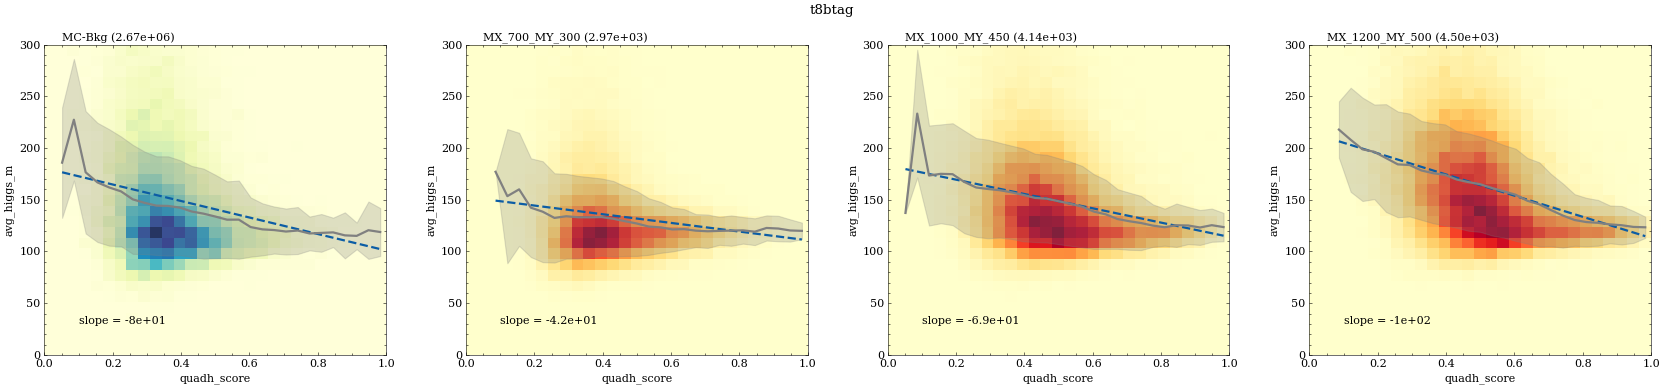

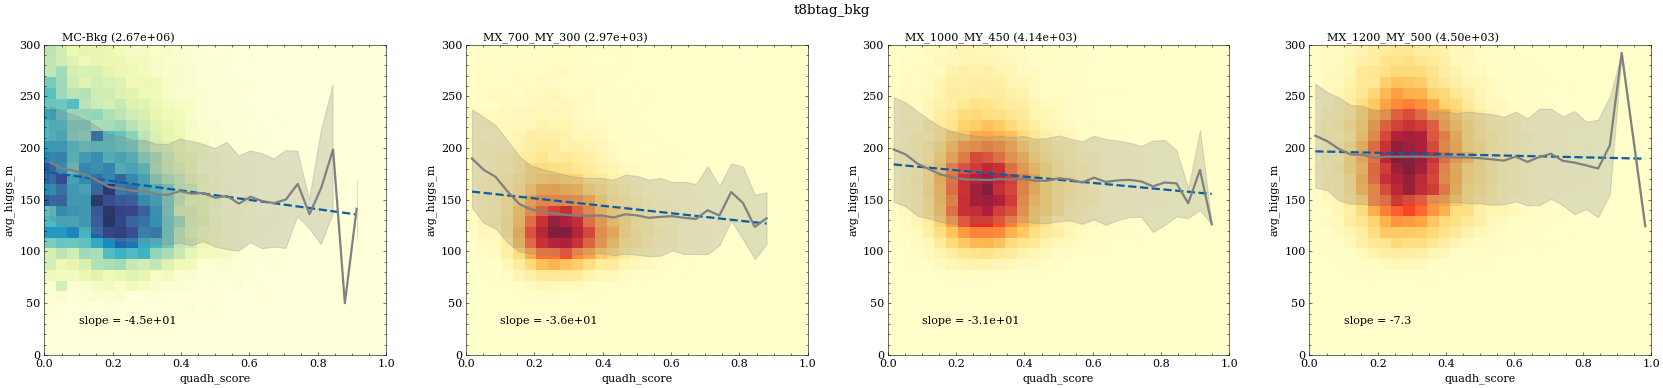

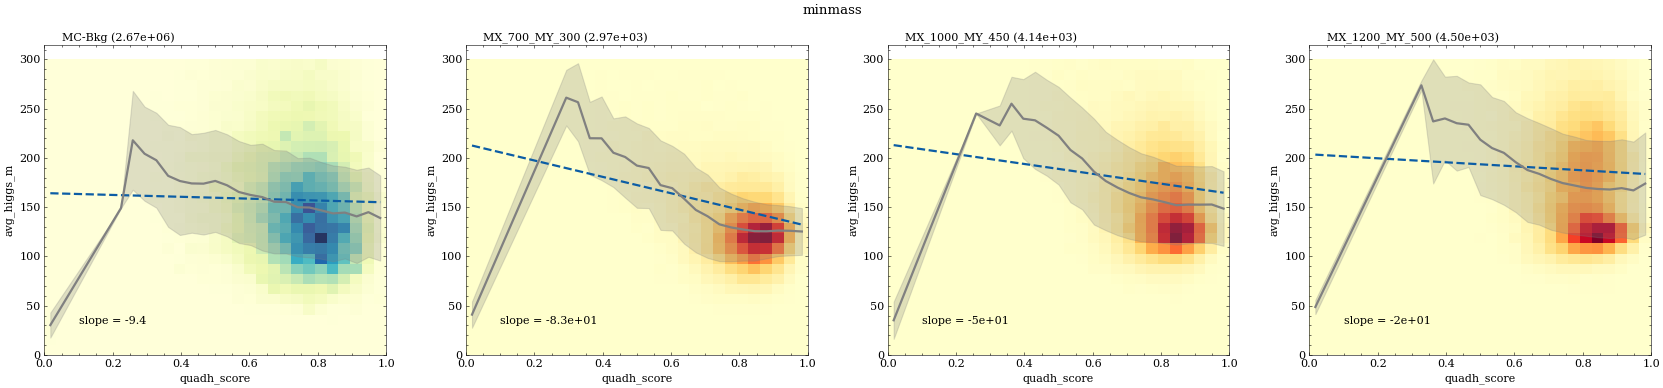

In [80]:
for i, (key, n) in enumerate(nn.items()):
    study.quick2d( 
        n.signal + n.bkg, 
        # masks = lambda t : t.quadh_score > n.bkg_quadh_score_mu,
        varlist=['quadh_score','avg_higgs_m'],
        binlist=[(0,1,30),(0,300,30)],
        exe=plot_histo2d_x_corr,
        suptitle=key,
        # figax=(fig, axs.flat[i])
    )

100%|██████████| 1/1 [00:04<00:00,  4.25s/it]


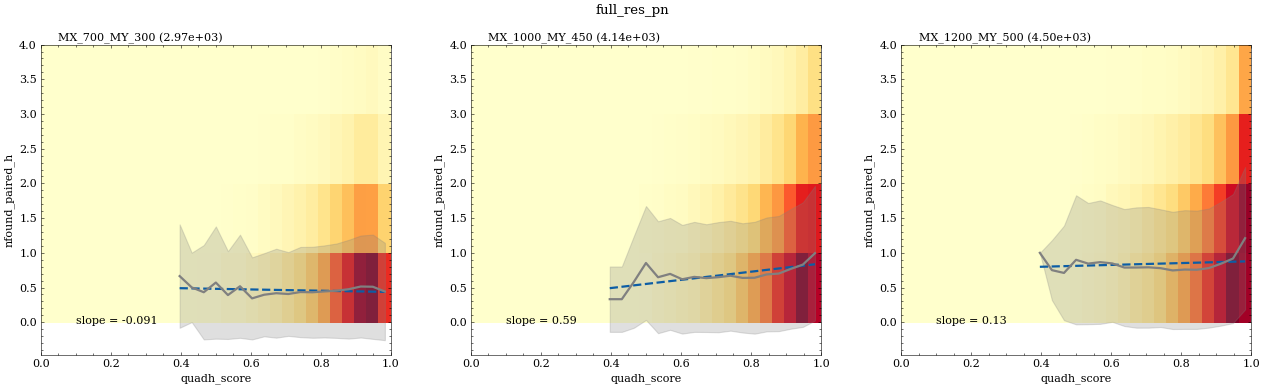

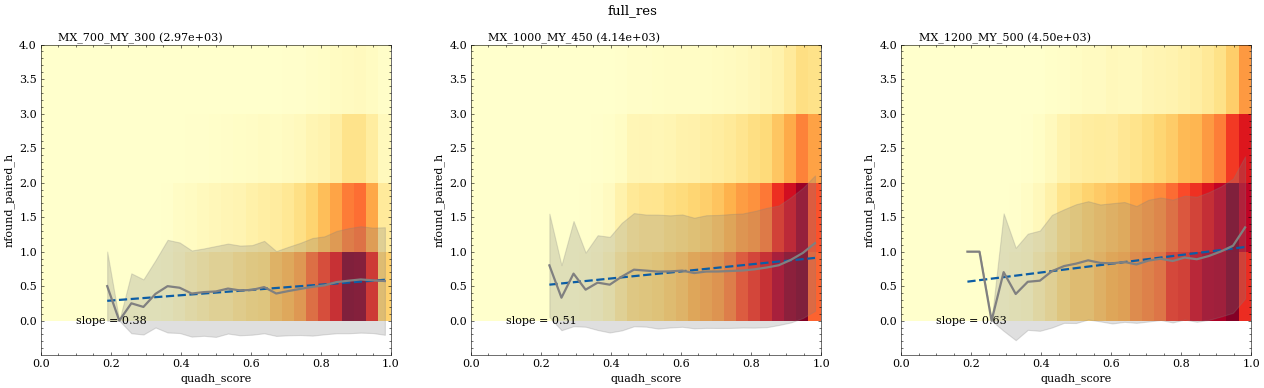

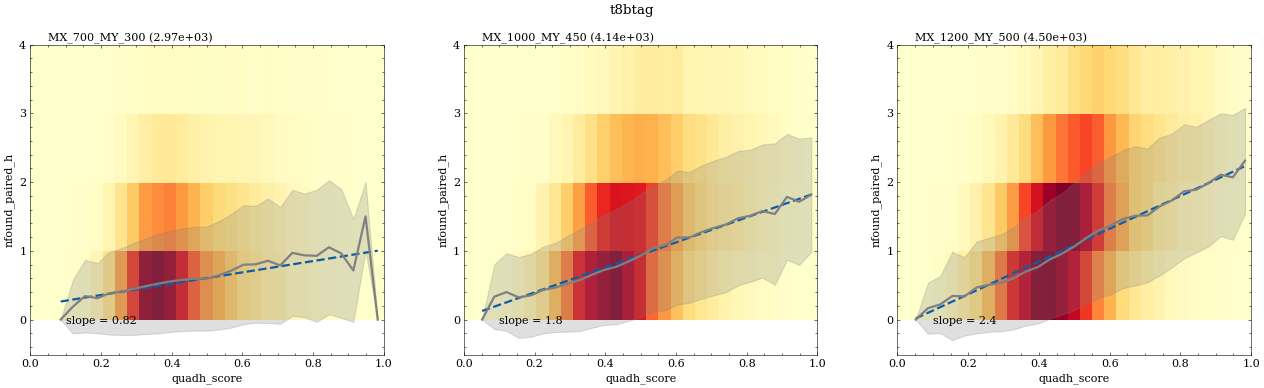

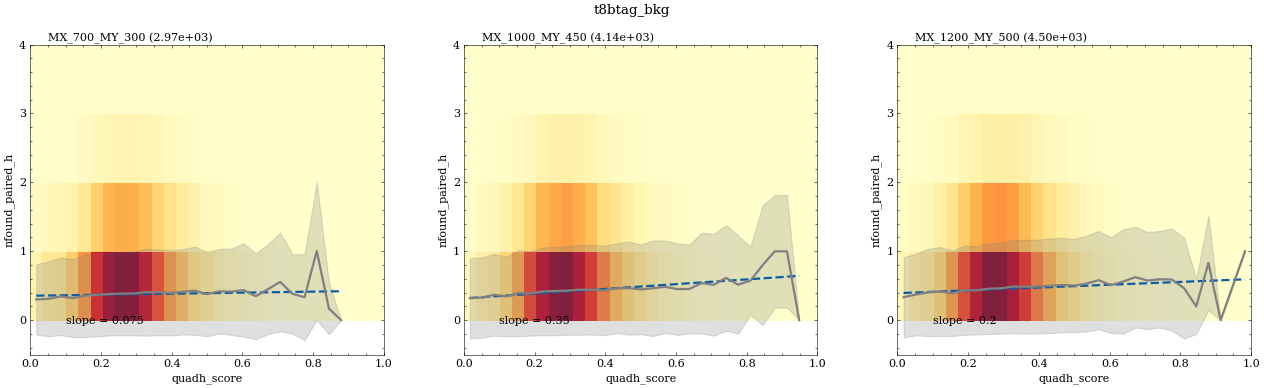

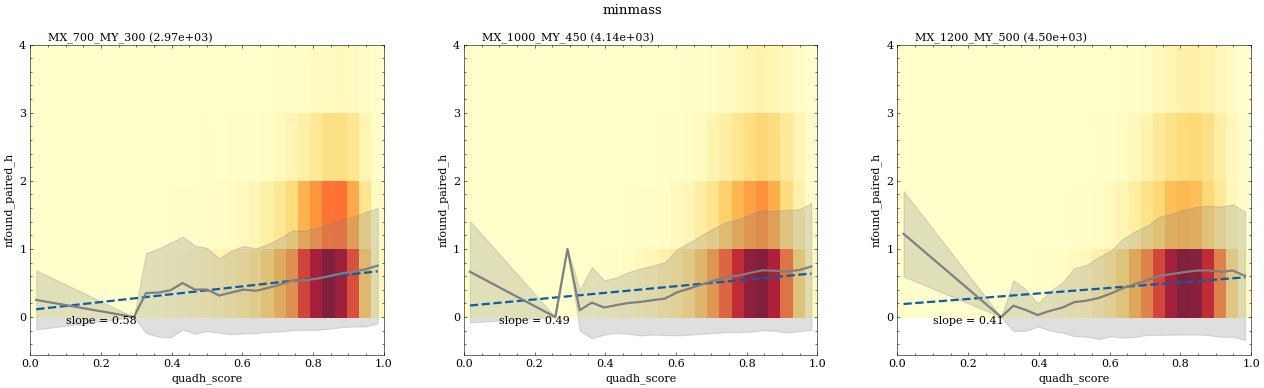

In [82]:
for i, (key, n) in enumerate(nn.items()):
    study.quick2d( 
        n.signal , 
        # masks = lambda t : t.quadh_score > n.bkg_quadh_score_mu,
        varlist=['quadh_score','nfound_paired_h'],
        binlist=[(0,1,30), np.arange(5)],
        exe=plot_histo2d_x_corr,
        suptitle=key,
        # figax=(fig, axs.flat[i])
    )